In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import *
from features import *
import matplotlib.pyplot as plt
import librosa
import librosa.display
import gc
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
TEST_SIZE = 0.4
RANDOM_SEED = 191

SAMPLE_RATE = 44100 / 3

N_FFT = 2048
HOP_LENGTH = 512
N_MEL_BINS = 128
N_MFCC = 24

WINDOW = 'blackmanharris'

LEARNING_RATE = 1e-3
BATCH_SIZE = 16

In [4]:
from prepare_data import sample_train_test_songs, form_audio_data_array

train_songs, val_songs, test_songs = sample_train_test_songs(test_size=TEST_SIZE, random_seed=RANDOM_SEED, include_val=True)
print(f'Train: {len(train_songs)} songs')
print(f'Val: {len(val_songs)} songs')
print(f'Test: {len(test_songs)} songs')

Train: 35 songs
Val: 5 songs
Test: 5 songs


In [5]:
# X_train, Y_train = form_audio_data_array(song_names=train_songs, sample_rate=SAMPLE_RATE, window=WINDOW, n_fft=N_FFT,
#                                          hop_length=HOP_LENGTH, n_mel=N_MEL_BINS, n_mfcc=N_MFCC, add_axis=True)
# X_val, Y_val = form_audio_data_array(song_names=val_songs, sample_rate=SAMPLE_RATE, window=WINDOW, n_fft=N_FFT,
#                                      hop_length=HOP_LENGTH, n_mel=N_MEL_BINS, n_mfcc=N_MFCC, add_axis=True)

with open(f'tmp/X_train_{RANDOM_SEED}_{N_MFCC}.npy', 'rb') as f:
    X_train = np.load(f)
    X_train = X_train[..., np.newaxis]
with open(f'tmp/Y_train_{RANDOM_SEED}_{N_MFCC}.npy', 'rb') as f:
    Y_train = np.load(f)
    Y_train = Y_train[..., np.newaxis]
with open(f'tmp/X_val_{RANDOM_SEED}_{N_MFCC}.npy', 'rb') as f:
    X_val = np.load(f)
    X_val = X_val[..., np.newaxis]
with open(f'tmp/Y_val_{RANDOM_SEED}_{N_MFCC}.npy', 'rb') as f:
    Y_val = np.load(f)
    Y_val = Y_val[..., np.newaxis]
with open(f'tmp/X_test_{RANDOM_SEED}_{N_MFCC}.npy', 'rb') as f:
    X_test = np.load(f)
    X_test = X_test[..., np.newaxis]
with open(f'tmp/Y_test_{RANDOM_SEED}_{N_MFCC}.npy', 'rb') as f:
    Y_test = np.load(f)
    Y_test = Y_test[..., np.newaxis]

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(971, 24, 290, 1) (971, 1)
(126, 24, 290, 1) (126, 1)
(104, 24, 290, 1) (104, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2 as L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [53]:
gc.collect()

25687

In [54]:
try:
    del model
except:
    pass

model = tf.keras.Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    BatchNormalization(),
#     Dropout(rate=0.5),
#     Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
#     MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
#     BatchNormalization(),
#     Dropout(rate=0.3),
#     Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
#     MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
#     BatchNormalization(),
    Flatten(),
    Dense(units=7, activation='softmax')
])

optimiser = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [55]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                    batch_size=BATCH_SIZE, epochs=100, callbacks=[early_stopping])

Train on 971 samples, validate on 126 samples
Epoch 1/100
971/971 [==============================] - 3s 3ms/sample - loss: 45.1744 - accuracy: 0.2142 - val_loss: 46.6688 - val_accuracy: 0.1508
Epoch 2/100
971/971 [==============================] - 2s 2ms/sample - loss: 6.2872 - accuracy: 0.6571 - val_loss: 15.6111 - val_accuracy: 0.3254
Epoch 3/100
971/971 [==============================] - 2s 2ms/sample - loss: 2.4723 - accuracy: 0.8115 - val_loss: 12.0831 - val_accuracy: 0.2937
Epoch 4/100
971/971 [==============================] - 2s 2ms/sample - loss: 2.4221 - accuracy: 0.8465 - val_loss: 22.0272 - val_accuracy: 0.3016
Epoch 5/100
971/971 [==============================] - 2s 2ms/sample - loss: 1.6256 - accuracy: 0.8826 - val_loss: 15.0006 - val_accuracy: 0.3413
Epoch 6/100
971/971 [==============================] - 2s 3ms/sample - loss: 1.0273 - accuracy: 0.9176 - val_loss: 19.6041 - val_accuracy: 0.3095
Epoch 7/100
971/971 [==============================] - 3s 3ms/sample - loss: 

In [56]:
train_results = model.evaluate(X_train, Y_train)
train_results

971/971 [==============================] - 1s 876us/sample - loss: 0.1006 - accuracy: 0.9907 - loss: 0.0831 - accura


[0.10058581980562559, 0.9907312]

In [57]:
val_results = model.evaluate(X_val, Y_val)
val_results

126/126 [==============================] - 0s 1ms/sample - loss: 24.0346 - accuracy: 0.4048


[24.034625704326327, 0.4047619]

In [58]:
test_results = model.evaluate(X_test, Y_test)
test_results

104/104 [==============================] - 0s 1ms/sample - loss: 22.8083 - accuracy: 0.3558


[22.808270674485428, 0.35576922]

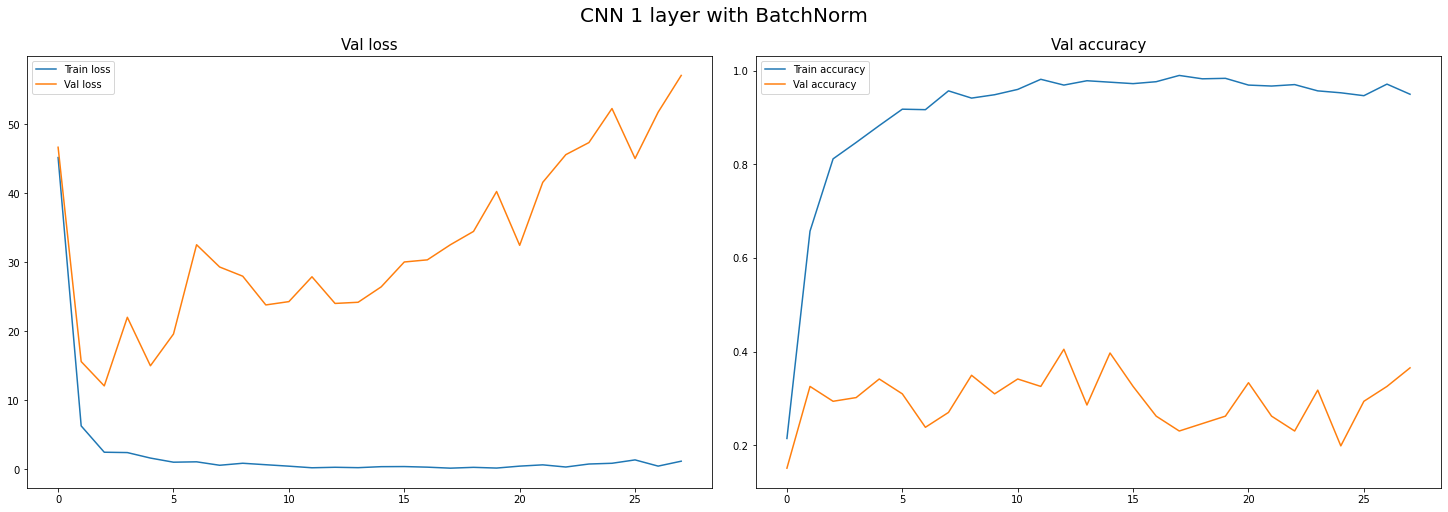

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7), constrained_layout=True)

ax[0].plot(history.history['loss'], label='Train loss')
ax[0].plot(history.history['val_loss'], label='Val loss')
ax[1].plot(history.history['accuracy'], label='Train accuracy')
ax[1].plot(history.history['val_accuracy'], label='Val accuracy')

fig.suptitle(f'CNN 1 layer with BatchNorm', fontsize=20)
ax[0].set_title(f'Val loss', fontsize=15)
ax[1].set_title(f'Val accuracy', fontsize=15)

ax[0].legend()
ax[1].legend()